In [230]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def arith(n):
    return int(n*(n+1)/2)

def mask(e):
    return e - torch.diag(torch.diag(e.detach()))

class LatSim(nn.Module):
    def __init__(self, nTgts, dp=0.5, dp2=0.1, method='same'):
        super(LatSim, self).__init__()
        self.nTgts = nTgts
        self.method = method
        self.masks = []
        if method == 'same':
            nMasks = nTgts
        elif method == 'diff':
            nMasks = 2*nTgts
        elif method == 'univ':
            nMasks = nTgts+1
        for i in range(nMasks):
            self.masks.append(nn.Parameter(
                1e-4*torch.randn(arith(263),2).float().cuda()
            ))
        self.masks = nn.ParameterList(self.masks)
        self.dp = nn.Dropout(p=dp)
        self.dp2 = nn.Dropout(p=dp2)
    
    def getLatentsAndEdges(self, x, i):
        if self.method == 'univ':
            y = torch.einsum('ac,ce->ae', x, self.masks[0])
            z = torch.einsum('ac,ce->ae', x, self.masks[i+1])
            e = y@z.T
            e = e+e.T
            return y, z, e
        elif self.method == 'diff':
            y = torch.einsum('ac,ce->ae', x, self.masks[2*i])
            z = torch.einsum('ac,ce->ae', x, self.masks[2*i+1])
            e = y@z.T
            e = e+e.T
            return y, z, e
        elif self.method == 'same':
            y = torch.einsum('ac,ce->ae', x, self.masks[i])
            e = y@y.T
            return y, y, e
        
    def forward(self, x, y, testIdcs=None):
        x = self.dp(x)
        res = []
        es = []
        for i in range(self.nTgts):
            nClass = y.shape[1] if y.dim() == 2 else 1
            _, _, e = self.getLatentsAndEdges(x[:,i,:], i)
            if testIdcs is not None:
                e[:,testIdcs] = 0
            e = self.dp2(e)
            e = mask(e)
            e[e == 0] = float('-inf')
            e = F.softmax(e, dim=1)
            es.append(e)
            res.append(e@y)
        return res, es
    
mseLoss = nn.MSELoss()

sim = LatSim(2, 0.5, 0.1, 'same')
print(sim.masks[0].shape)
print(sim.masks[0][0:5,0:5])

sim.load_state_dict(torch.load('../../Work/LatentSim/sim.pyt'))

print(sim.masks[0].shape)
print(sim.masks[0][0:5,0:5])

torch.Size([34716, 2])
tensor([[-8.4318e-05,  3.4579e-05],
        [-1.2620e-04, -8.3750e-05],
        [-4.0754e-05, -3.6589e-05],
        [ 1.2061e-04, -1.7691e-04],
        [-6.0020e-05,  2.4674e-04]], device='cuda:0', grad_fn=<SliceBackward0>)
torch.Size([34716, 2])
tensor([[-0.0006,  0.0024],
        [-0.0022, -0.0022],
        [-0.0025, -0.0005],
        [ 0.0016, -0.0016],
        [-0.0030, -0.0006]], device='cuda:0', grad_fn=<SliceBackward0>)


In [136]:
import pickle

with open('../../PNC_Good/MegaMeta3.pkl', 'rb') as f: 
    meta = pickle.load(f)
    
print('Complete')

Complete


In [137]:
with open('../../Work/LatentSim/Splits.pkl', 'rb') as f:
    keys, groups = pickle.load(f)
    
print(len(keys))
print(len(groups[0][0])+len(groups[0][1]))
print('Complete')

620
620
Complete


In [138]:
import numpy as np

nback = np.stack([meta[key]['nback'] for key in keys])
emoid = np.stack([meta[key]['emoid'] for key in keys])

print(nback.shape)
print(emoid.shape)

(620, 264, 231)
(620, 264, 210)


In [139]:
from nilearn.connectome import ConnectivityMeasure

def getFC(timeSeries, kind='correlation', transpose=True):
    connMeasure = ConnectivityMeasure(kind=kind)
    if transpose:
        timeSeries = np.transpose(timeSeries, axes=(0,2,1))
    return connMeasure.fit_transform(timeSeries)

nback_p = getFC(nback)
emoid_p = getFC(emoid)

print(nback_p.shape)

(620, 264, 264)


In [140]:
import torch

def convertTorch(p):
    t = torch.from_numpy(p).float()
    u = []
    for i in range(t.shape[0]):
        u.append(t[i][torch.triu_indices(264,264,offset=1).unbind()])
    return torch.stack(u).cuda()

nback_p_t = convertTorch(nback_p)
emoid_p_t = convertTorch(emoid_p)

print(nback_p_t.shape)
print(emoid_p_t.shape)
print('Complete')

torch.Size([620, 34716])
torch.Size([620, 34716])
Complete


In [141]:
age = np.stack([meta[key]['AgeInMonths'] for key in keys])
gen = np.stack([np.array([meta[key]['Gender'] == 'M', meta[key]['Gender'] == 'F']) for key in keys]).astype(int)
wrt = np.stack([meta[key]['wratStd'] for key in keys])

print(age.shape)
print(gen.shape)
print(wrt.shape)

(620,)
(620, 2)
(620,)


In [142]:
age_t = torch.from_numpy(age).float().cuda()
gen_t = torch.from_numpy(gen).float().cuda()
wrt_t = torch.from_numpy(wrt).float().cuda()

print('Complete')

Complete


In [231]:
Y0 = nback_p_t@sim.masks[0]
Y1 = emoid_p_t@sim.masks[1]

print(Y0.shape)
print(Y1.shape)

torch.Size([620, 2])
torch.Size([620, 2])


In [232]:
# Min L2 norm solution

nback_min,res0,_,_ = torch.linalg.lstsq(nback_p_t, Y0)
emoid_min,res1,_,_ = torch.linalg.lstsq(emoid_p_t, Y1)
print(res0)
print(res1)
print(nback_min[0:5,0:2])
print(emoid_min[0:5,0:2])
print(torch.max(torch.abs(Y0 - nback_p_t@nback_min)))
print(torch.max(torch.abs(Y1 - emoid_p_t@emoid_min)))

tensor([], device='cuda:0', grad_fn=<LinalgLstsqBackward0>)
tensor([], device='cuda:0', grad_fn=<LinalgLstsqBackward0>)
tensor([[-2.1998e-03,  1.1844e-03],
        [-1.5870e-03, -6.6102e-05],
        [-2.1595e-03, -7.0595e-05],
        [-5.3518e-05, -9.0019e-04],
        [-1.1438e-03, -6.7578e-04]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[ 0.0032,  0.0009],
        [-0.0059, -0.0040],
        [-0.0035, -0.0016],
        [-0.0009, -0.0002],
        [-0.0017, -0.0009]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor(4.0531e-06, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(5.2452e-06, device='cuda:0', grad_fn=<MaxBackward1>)


In [244]:
pool = [emoid_min.detach()]

print('Complete')

Complete


In [245]:
import random

class Sample(nn.Module):
    def __init__(self, W):
        super(Sample, self).__init__()
        self.W = nn.Parameter(2e-3*torch.randn(W.shape).float().cuda())
        
    def forward(self, X):
        return X@self.W
    
def poolLoss(samp, pool):
    neg = random.choices(pool, k=5)
    loss = 0
    for s in neg:
        loss += 3e-3*torch.linalg.matrix_norm(samp-s)
    return loss/len(neg)

pPeriod = 1000
nEpochs = 10000

X = emoid_p_t.detach()
Y = Y1.detach()

for i in range(40):
    print(f'Iteration {i}')
    
    samp = Sample(emoid_min)
    optim = torch.optim.Adam(samp.parameters(), lr=1e-4, weight_decay=1e-5)
    
    found = False
    
    for epoch in range(nEpochs):
        optim.zero_grad()
        Yhat = samp(X)
        loss0 = mseLoss(Yhat, Y)
        loss1 = poolLoss(samp.W, pool)
        loss = loss0-loss1
        loss.backward()
        optim.step()
        if epoch % pPeriod == 0 or epoch == nEpochs-1:
            print(f'epoch {epoch} loss={(float(loss0), float(loss1))}')
        if loss0 < 1e-6 and loss1 > 1e-3:
            pool.append(samp.W.detach())
            found = True
            break
    if not found:
        print('Failed to find sample')
        break

Iteration 0
epoch 0 loss=(1.4833598136901855, 0.0024098162539303303)
epoch 1000 loss=(0.00035089949960820377, 0.0016974102472886443)
Iteration 1
epoch 0 loss=(1.5070706605911255, 0.002639301586896181)
epoch 1000 loss=(0.00033883674768731, 0.0018275808542966843)
Iteration 2
epoch 0 loss=(1.4909825325012207, 0.0030026391614228487)
epoch 1000 loss=(0.0003766822919715196, 0.0020894522313028574)
Iteration 3
epoch 0 loss=(1.337560772895813, 0.002870397176593542)
epoch 1000 loss=(0.00025831570383161306, 0.002338666934520006)
Iteration 4
epoch 0 loss=(1.4954783916473389, 0.00263865920715034)
epoch 1000 loss=(0.0003382137219887227, 0.0022111348807811737)
Iteration 5
epoch 0 loss=(1.6327301263809204, 0.002747640712186694)
epoch 1000 loss=(0.0004038283950649202, 0.002199877053499222)
Iteration 6
epoch 0 loss=(1.5539569854736328, 0.002979846438392997)
epoch 1000 loss=(0.0003949328965973109, 0.0023371155839413404)
Iteration 7
epoch 0 loss=(1.4987484216690063, 0.002975241281092167)
epoch 1000 loss=(

In [246]:
print(emoid_min)
print(samp.W)
print(emoid_p_t@samp.W)
print(Y)

tensor([[ 0.0032,  0.0009],
        [-0.0059, -0.0040],
        [-0.0035, -0.0016],
        ...,
        [ 0.0040,  0.0015],
        [ 0.0008, -0.0008],
        [-0.0009, -0.0002]], device='cuda:0', grad_fn=<LinalgLstsqBackward0>)
Parameter containing:
tensor([[ 0.0042,  0.0013],
        [-0.0052, -0.0036],
        [-0.0040, -0.0013],
        ...,
        [ 0.0049,  0.0034],
        [ 0.0003, -0.0024],
        [ 0.0025, -0.0018]], device='cuda:0', requires_grad=True)
tensor([[ 0.4479, -1.6010],
        [ 0.8443, -0.9179],
        [ 0.9085, -0.9777],
        ...,
        [ 0.9812, -0.8054],
        [ 0.2461, -2.2752],
        [ 0.6499, -1.3513]], device='cuda:0', grad_fn=<MmBackward0>)
tensor([[ 0.4495, -1.6001],
        [ 0.8457, -0.9176],
        [ 0.9131, -0.9764],
        ...,
        [ 0.9823, -0.8058],
        [ 0.2494, -2.2735],
        [ 0.6522, -1.3514]], device='cuda:0')


In [247]:
def validate(model, X, y, testIdcs):
    model.eval()
    with torch.no_grad():
        res, _ = model(X, y, testIdcs)
        avg = torch.mean(torch.stack(res), dim=0)
        if res[0].dim() == 1:
            loss = mseLoss(avg[testIdcs], y[testIdcs]).cpu().numpy()**0.5
        else:
            corr = (torch.argmax(avg, dim=1) == torch.argmax(y, dim=1))[testIdcs]
            loss = torch.sum(corr)/len(testIdcs)
    model.train()
    return loss

para = [nback_p_t, emoid_p_t]
rmse = []

X = torch.stack(para, dim=1)
sim = LatSim(len(para), 0.5, 0.1, 'same')
sim.masks[0] = nn.Parameter(nback_min)
sim.masks[1] = nn.Parameter(samp.W.detach())

i = 3

trainIdcs = groups[i][0][0:496]
validIdcs = groups[i][0]
testIdcs = groups[i][1]

Xt = X[trainIdcs]
Xv = X[validIdcs]

trainLoss = []
validLoss = []

vIdcs1 = np.arange(496,len(validIdcs))
vIdcs2 = validIdcs[496:]
vIdcs3 = np.concatenate([testIdcs, vIdcs2])

loss0 = validate(sim, X, age_t, testIdcs)

rmse.append((float(loss0)))

print(i, end=' ')
print(rmse[-1])

3 23.431249618530273


In [248]:
import matplotlib.pyplot as plt

def heatmap(cuda):
    iu = np.triu_indices(264, 1)
    m = np.zeros([264,264])
    v = cuda.detach().cpu().numpy()
    m[iu] = v
    m = m + m.T
    return m

pool_t = torch.stack(pool)
pool_t = torch.einsum('ab,cbd->acbd', emoid_p_t.cpu(), pool_t.cpu())
pool_t = pool_t.reshape(620*len(pool),-1,2)
poolSigma = torch.std(pool_t, dim=0)
poolMu = torch.mean(pool_t, dim=0)

print('Complete')

Complete


In [249]:
EXY = torch.mean(pool_t[:,:,0]*pool_t[:,:,1], dim=0)**2
mu0 = poolMu[:,0]
mu1 = poolMu[:,1]
sigma0 = poolSigma[:,0]
sigma1 = poolSigma[:,1]

print(torch.mean(EXY))
print(torch.mean(mu0))
print(torch.mean(mu1))
print(torch.mean(sigma0))
print(torch.mean(sigma1))

tensor(5.2544e-13)
tensor(2.5403e-05)
tensor(-3.5295e-05)
tensor(0.0008)
tensor(0.0007)


In [250]:
VarX = sigma0**4+2*sigma0**2*mu0**2
VarY = sigma1**4+2*sigma1**2*mu1**2

score = VarX + VarY + 2*EXY - 2*mu0**2*mu1**2
print(torch.max(score))
print(torch.min(score))

tensor(4.4053e-10)
tensor(4.4747e-14)


In [251]:
ht = heatmap(score)

biggest = np.argsort(ht.flatten())[-20:]
for i in biggest:
    x,y = np.unravel_index(i, (264,264))
    print(f'{i} {(x,y)} {ht[x,y]}')

9671 (36, 167) 1.396941173847921e-10
44124 (167, 36) 1.396941173847921e-10
33979 (128, 187) 1.4641356183009435e-10
49496 (187, 128) 1.4641356183009435e-10
21901 (82, 253) 1.5037510125992526e-10
66874 (253, 82) 1.5037510125992526e-10
23699 (89, 203) 1.521292397610452e-10
53681 (203, 89) 1.521292397610452e-10
19632 (74, 96) 1.8774115595476815e-10
25418 (96, 74) 1.8774115595476815e-10
19645 (74, 109) 1.8814441671288762e-10
28850 (109, 74) 1.8814441671288762e-10
1236 (4, 180) 2.0500072472895425e-10
47524 (180, 4) 2.0500072472895425e-10
27794 (105, 74) 2.5331528541450155e-10
19641 (74, 105) 2.5331528541450155e-10
22778 (86, 74) 2.6329963209725804e-10
19622 (74, 86) 2.6329963209725804e-10
47861 (181, 77) 4.405346920588471e-10
20509 (77, 181) 4.405346920588471e-10


[5.13899610e-12 5.22666514e-12 5.41499040e-12 5.75550306e-12
 6.54985288e-12 6.72713541e-12 7.11396006e-12 7.21444844e-12
 1.07402477e-11 1.47998256e-11]
[213  64 180  36  77  94  92   4  26  74]


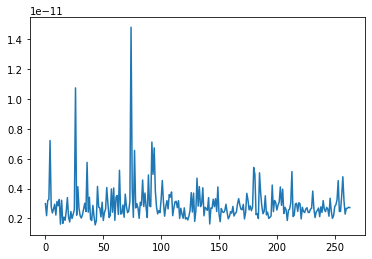

In [252]:
means = np.mean(ht, axis=0)
print(np.sort(means)[-10:])
print(np.argsort(means)[-10:])

plt.plot(means)
plt.show()

/home/anton/.conda/envs/torch/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


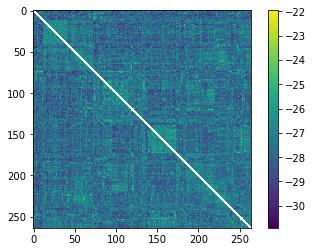

In [243]:
plt.imshow(np.log(ht))
plt.colorbar()
plt.show()